## Regression and Evaluation on Synthetic Data

In [1]:
# import regressors
from sklearn.dummy import DummyRegressor   
from sklearn.linear_model import (LinearRegression, 
                                  Lasso, LassoLars, Ridge, ElasticNet, 
                                  BayesianRidge, ARDRegression,
                                  PassiveAggressiveRegressor,
                                  SGDRegressor)
from sklearn.svm import SVR, NuSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, 
                              ExtraTreesRegressor, 
                              AdaBoostRegressor,
                              GradientBoostingRegressor,)

# import preprocessing routines
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# import utils for hyper-param search and evaluation metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import (cross_val_score,
                                     learning_curve,
                                     validation_curve)
from sklearn.metrics import (mean_squared_error, 
                             median_absolute_error, 
                             r2_score,  
                             explained_variance_score,  
                             make_scorer)

# import libs to generate data
from sklearn.datasets import make_regression, make_friedman1, make_friedman2, make_friedman3

# import ipywidgets for interaction
from ipywidgets import *  
from IPython.display import display, Image
plt.style.use('fivethirtyeight')

# ignore deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# func to generate synthetic regression data
def gen_regression_data(N=100,n_features=30, n_informative=10, nr=0):
    X, y, w = make_regression(n_samples=N, n_features=n_features, n_informative=n_informative,  
                              bias=5, effective_rank=5, tail_strength=15, noise=10,
                              n_targets=1, coef=True, random_state = nr
                             )
    return X, y, w

In [3]:
# func to generate synthetic poly data
def gen_poly_data(N,n_features=10):
    X, y = make_friedman1(n_samples=N, n_features=n_features, noise=1, random_state=1 )
    y = (y - np.mean(y))/np.std(y)
    return X, y, None

In [4]:
# func to generate synthetic multiplication and reciprocation data
def gen_multi_recipro_data(N):
    X, y = make_friedman2(n_samples=N, noise=1, random_state=1 )
    y = (y - np.mean(y))/np.std(y)
    return X, y, None

In [5]:
# func to generate synthetic sigmoid data
def gen_sigmoid_data(N,n_features=10):
    X, y = make_friedman3(n_samples=N, noise=1, random_state=1 )
    y = (y - np.mean(y))/np.std(y)
    return X, y, None

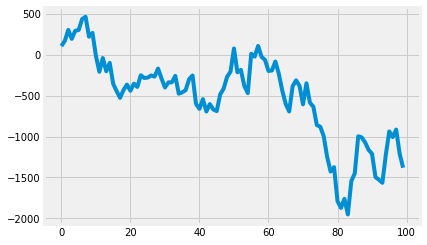

In [6]:
# gen and plot the data
N=100 # N - number of points
X, y, w = gen_regression_data(N, nr=5)
cy = np.cumsum(y)
plt.plot(cy);

In [7]:
# list regressors
estimators = [
    
    'DummyRegressor',    
    
    'LinearRegression',
    'PolyRegressor',  # polynomial + linear
    'Lasso',
    'LassoLars',
    'Ridge',
    'ElasticNet',
    
    'BayesianRidge',
    'ARDRegression',
    'PassiveAggressiveRegressor',
    'SGDRegressor', 
    
    'SVR', 
    'NuSVR',
    
    'KNeighborsRegressor',
    
    'DecisionTreeRegressor',
    'RandomForestRegressor',
    'ExtraTreesRegressor',  
    
    'AdaBoostRegressor',
    'GradientBoostingRegressor',
    
]

In [8]:
# specify hyper-space search parameters 

estimator_gridsearch_params = {
    
    'DummyRegressor': {'search_hparams': {
        'strategy':['mean', 'median'],
    }},
    
    'LinearRegression': {'search_hparams': {
        'normalize': [True],
    }},
    
    'PolyRegressor': {'search_hparams': {
        'poly__degree': [2,3,5],
        'linear__normalize': [True],
        'linear__n_jobs': [-1],
    }},
    
    'Lasso': {'search_hparams': {
        'alpha': [.2,.5,.8,1],
        'max_iter': [100,500,1000],
        'positive': [False, True],
        'normalize':[True],
        'selection':['cyclic','random'],
    }},    
    
    'LassoLars': {'search_hparams': {
        'alpha':[.3,.5,1],
        'normalize':[True], 
        'max_iter':[500,1000], 
    }},
    
    'Ridge': {'search_hparams': {
        'alpha':[.3,.5,1], 
        'normalize':[True], 
        'solver':['sag'], 
        'max_iter':[1000,2000],
    }},    
    
    'BayesianRidge' : {'search_hparams': {
        'n_iter':[300,500,700],
        'alpha_1': np.logspace(-5,0,6),
        'alpha_2': np.logspace(-5,0,6),
        'normalize':[True]
    }},    
    
    'ARDRegression': {'search_hparams': {
        'n_iter':[300,500],
        'normalize':[True]
    }},
    
    'PassiveAggressiveRegressor' : {'search_hparams': {
            'C':[0.1,.3,.8,1], 
            'n_iter':[5,10,30], 
    }},      
    
    'SVR': {'search_hparams': {
        'C': [.3,.5,.8,1],  
        'gamma':['scale'],
    }}, 
    'NuSVR': {'search_hparams': {
        'C': [.3,.5,.8,1],
        'nu':[.3,.5,.8],  
        'gamma':['scale'],
    }},
    
    'KNeighborsRegressor': {'search_hparams': {
        'n_neighbors': [3,5,10],
        'weights':['uniform','distance'],
        'algorithm':['ball_tree', 'kd_tree', 'brute'],
        'leaf_size':[10,30,50],
    }},

    'DecisionTreeRegressor': {'search_hparams': {
        'max_features': ['auto','sqrt','log2'],
        'max_depth': [3,5,10],
    }}, 
    
    'ExtraTreesRegressor': {'search_hparams': {
        'max_depth': [3,5,10],
        'max_features':['auto','sqrt','log2',None],   
        'n_estimators':[100,200],
    }},    
  
}

estimator_randomizedsearch_params = {
    
    'ElasticNet': {'search_hparams': {
        'alpha':[.1,.3,.5,.8,1],
        'l1_ratio':[.1,.3,.5,.8,1],
        'normalize':[True], 
        'max_iter':[500,1000,1500], 
        'selection':['cyclic','random'],
    }},

    'SGDRegressor': {'search_hparams': {
        'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
        'penalty': [None, 'l2', 'l1', 'elasticnet'],
        'alpha': np.logspace(-5,1,7),
        'l1_ratio': [0,.2,.5,.8,1],
        'n_iter': [3,5,10,25],
        'learning_rate':['optimal', 'invscaling']
    }},
    
    'RandomForestRegressor': {'search_hparams': {
        'n_estimators': [50,100,300],
        'max_depth': [3,5,10],
        'max_features': ['auto','sqrt','log2'],
    }},    
    
    'AdaBoostRegressor': {'search_hparams': {
        'n_estimators':[100,300,500],
        'learning_rate': np.logspace(-4,0,5),
        'loss': ['linear', 'square', 'exponential'],
    }},
    
    'GradientBoostingRegressor': {'search_hparams': {
        'loss':['ls', 'lad', 'huber', 'quantile'], 
        'learning_rate':[0.01,0.05,0.1], 
        'n_estimators':[100,300,500], 
        'subsample':[0.3,0.5,.8,1], 
        'max_depth':[3,5],
        'max_features':['auto','sqrt','log2'],
    }},

}

In [9]:
# train-test split
test_size_pct = 0.2
test_size = int((test_size_pct)*N)

X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]


# arrays to keep scores
best_mse_scores = []
best_mae_scores = []
best_evs_scores = []
best_r2_scores = []

for est_str in estimators:
 
    # instantiate regressors
    if est_str == 'PolyRegressor':
        est = Pipeline([('poly', PolynomialFeatures()), ('linear', LinearRegression()) ])
    else:
        est = eval( est_str + '()' ) 
    s_est = None
    hyper_params = None
    
    
    if est_str in estimator_gridsearch_params:
        hyper_params = estimator_gridsearch_params[est_str]['search_hparams']
        s_est = GridSearchCV( est, param_grid=hyper_params, cv=5, n_jobs=-1, )
        
    elif est_str in estimator_randomizedsearch_params:
        hyper_params = estimator_randomizedsearch_params[est_str]['search_hparams']
        s_est = RandomizedSearchCV( est, param_distributions=hyper_params, n_iter=30, cv=5, n_jobs=-1, random_state=0)
        
    else:
        raise Exception('wrong est_str (%s)' % est_str)  

        
    # fit and predict with meta-estimators
    s_est.fit(X_train, y_train.ravel())
    y_pred = s_est.predict(X_test)
    
    
    # compute scores
    best_est = s_est.best_estimator_
    print(best_est)
    best_mse_scores.append( (best_est.__class__.__name__, mean_squared_error(y_test, y_pred)) )
    best_mae_scores.append( (best_est.__class__.__name__, median_absolute_error(y_test, y_pred)) )
    best_evs_scores.append( (best_est.__class__.__name__, explained_variance_score(y_test, y_pred)) )        
    best_r2_scores.append ( (best_est.__class__.__name__, r2_score(y_test, y_pred) ))
    print()

DummyRegressor(constant=None, quantile=None, strategy='mean')

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True))])

Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=True, precompute=False, random_state=None,
   selection='random', tol=0.0001, warm_start=False)

LassoLars(alpha=0.3, copy_X=True, eps=2.220446049250313e-16,
     fit_intercept=True, fit_path=True, max_iter=500, normalize=True,
     positive=False, precompute='auto', verbose=False)

Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=None, solver='sag', tol=0.001)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=1,
      max_iter=500, normalize=True, positive=False, precompute=False,
     

In [10]:
# sort regressors by avg sore

df = pd.DataFrame(best_mse_scores, columns=['Est','MSE']).sort_values(by='MSE', ascending=False).reset_index(drop=1)
mse_s = pd.Series(df.index, index=df.Est)

df = pd.DataFrame(best_mae_scores, columns=['Est','MAE']).sort_values(by='MAE', ascending=False).reset_index(drop=1)
mae_s = pd.Series(df.index, index=df.Est)

df = pd.DataFrame(best_evs_scores, columns=['Est','EVS']).sort_values(by='EVS', ascending=True).reset_index(drop=1)
eva_s = pd.Series(df.index, index=df.Est)

df = pd.DataFrame(best_r2_scores, columns=['Est','R2']).sort_values(by='R2', ascending=True).reset_index(drop=1)
r2_s = pd.Series(df.index, index=df.Est)

df = (pd.DataFrame(pd.concat([mse_s,mae_s,eva_s,r2_s], axis=1, sort=False))
          .reset_index()
          .rename(columns={'index':'Est',0:'MSE',1:'MAE',2:'EVS',3:'R2'}))

df.insert(1,'CumScore', df.iloc[:,1:].apply(np.sum, axis=1))
df = df.sort_values(by='CumScore', ascending=False).reset_index(drop=True)
df

,Est,CumScore,MSE,MAE,EVS,R2
0,ElasticNet,72,18,18,18,18
1,Lasso,68,17,17,17,17
2,LassoLars,63,16,15,16,16
3,ARDRegression,61,15,16,15,15
4,BayesianRidge,54,14,12,14,14
5,LinearRegression,50,13,11,13,13
6,SGDRegressor,50,12,14,12,12
7,PassiveAggressiveRegressor,46,11,13,11,11
8,Ridge,40,10,10,10,10
9,GradientBoostingRegressor,33,9,6,9,9


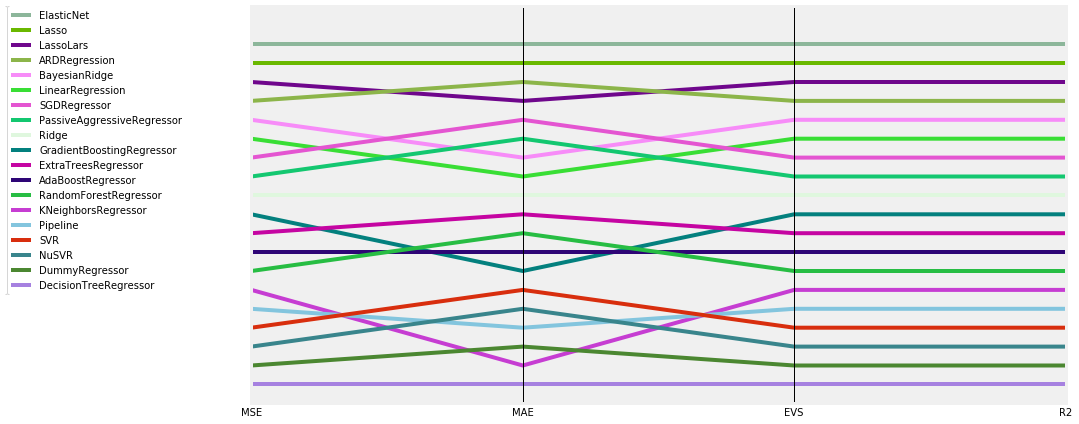

In [11]:
# show regressors in a parallel chart

plt.figure(figsize=(16,6))
plt.ylim(-.1, len(estimators)+1)
from pandas.plotting import parallel_coordinates
parallel_coordinates(df.drop('CumScore',axis=1), 'Est')
plt.yticks(())
plt.ylim(-1, len(estimators)+1)
plt.legend(bbox_to_anchor=(-.3, 1), loc=1, mode="expand", borderaxespad=0.)
plt.tight_layout();

In [12]:
# explore regressors interactively
    
w_est_str = widgets.Dropdown(options=estimators, description='Estimator ', continuous_update=False, value=df.iloc[0,0])
w_split_pct = widgets.FloatSlider(min=0.05, max=0.95, step=0.01, value=0.8, description='Train-Test Split Pct', continuous_update=False)
w_show_train = widgets.Checkbox(value=True, description='Training Data Shown')
w_best_est = Textarea(disabled=True, layout=Layout(width='100%', height='200px'))
    
@interact(est_str=w_est_str, split_pct=w_split_pct, show_train=w_show_train,)
def show_prediction(est_str, split_pct, show_train):
    
    # train-test split
    test_size = int((1-split_pct)*N)
    
    X_train, X_test = X[:-test_size], X[-test_size:]
    y_train, y_test = y[:-test_size], y[-test_size:]
    
    # instantiate est
    if est_str == 'PolyRegressor':
        est = Pipeline([('poly', PolynomialFeatures()), ('linear', LinearRegression()) ])
    else:
        est = eval( est_str + '()' ) 
    s_est = None
    hyper_params = None
    
    # search hyperparams
    if est_str in estimator_gridsearch_params:
        hyper_params = estimator_gridsearch_params[est_str]['search_hparams']
        s_est = GridSearchCV( est, param_grid=hyper_params, cv=5, n_jobs=-1, )
        
    elif est_str in estimator_randomizedsearch_params:
        hyper_params = estimator_randomizedsearch_params[est_str]['search_hparams']
        s_est = RandomizedSearchCV( est, param_distributions=hyper_params, n_iter=30, cv=5, n_jobs=-1, )
        
    else:
        raise Exception('wrong est_str (%s)' % est_str)  
    
    s_est.fit(X_train, y_train.ravel())
    best_est = s_est.best_estimator_
    w_best_est.value = str(best_est)
    
    # predict
    y_pred = best_est.predict(X_test)
    w_best_est.value += '\n"R2" Score: %s' % str(best_est.score(X_test, y_test))
    
    # plot lines
    vshift = np.cumsum(y_train)[-1]
    if show_train:
        plt.plot(np.arange(len(y_train)),np.cumsum(y_train),'-',label='Training Data') 
        plt.xlim(0,N)
    else:
        plt.xlim(len(y_train),N)
    
    plt.plot(np.arange(N-len(y_test),N),vshift+np.cumsum(y_test)-y_test[0],'-',c='c',label='Test Data')
    plt.plot(np.arange(N-len(y_pred),N),vshift+np.cumsum(y_pred)-y_pred[0],':',lw=3, c='m',label='Prediction')
    
    plt.scatter(len(y_train), vshift, s=700, c='m',marker='*')
    plt.vlines(len(y_train),*plt.ylim(),lw=9,color='r',alpha=.1,label='Test size %s'%(len(y_test)))
    plt.legend(framealpha=.3,loc=0)
    
display(w_best_est);

interactive(children=(Dropdown(description='Estimator ', index=6, options=('DummyRegressor', 'LinearRegression…

Textarea(value='ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=1,\n      max_iter=1000, norma…

## Feature Selection

In [13]:
# to generate data
from sklearn.datasets import make_regression

# to draw ipywidgets
from ipywidgets import *  
from IPython.display import display, Image
plt.style.use('bmh')

In [14]:
# func to generate synthetic regression data
def gen_regression_data(n_samples=100,n_features=30, n_informative=10, rs=0):
    
    X, y, w = make_regression(n_samples=N, n_features=n_features, n_informative=n_informative,  
                              bias=5, effective_rank=5, tail_strength=15, noise=10,
                              n_targets=1, coef=True, random_state = rs)
    return X, y, w

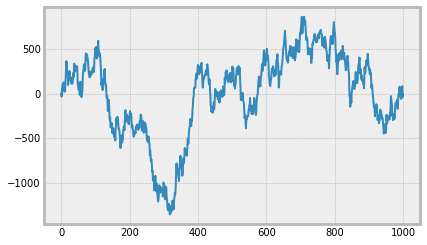

In [15]:
##### gen and plot the data
N=1000 # N - number of points
X, y, w = gen_regression_data(n_samples=N, rs=19358)
cy = np.cumsum(y)
plt.plot(cy);

In [16]:
# show nonzero indexes of the returned weights
w_indexes = np.nonzero(w)[0]
w_indexes

array([ 1,  3, 12, 13, 15, 19, 20, 23, 25, 29])

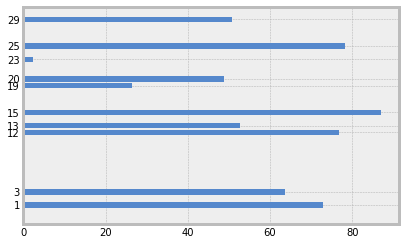

In [17]:
# show up the returned weights (the true condition)
plt.barh(range(30), w, color='#5588cc', height=.8)
plt.yticks(w_indexes);

In [18]:
# show correlation of X features to y response 
X_df = pd.DataFrame(X)
y_s = pd.Series(y)
corr = X_df.corrwith(y_s)
w_indexes, np.where( np.abs(corr) > .1 )[0] 

(array([ 1,  3, 12, 13, 15, 19, 20, 23, 25, 29]),
 array([ 1,  3, 10, 12, 13, 15, 18, 20, 25, 29]))

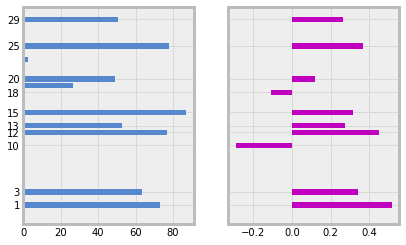

In [19]:
# show up the correlation
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True)
ax1.barh(range(30), w, height=.8, color='#5588cc')
ax2.barh(np.arange(30), np.where(np.abs(corr) > .1, corr, 0), height=.8, color='m')
ax2.set_yticks( np.where( np.abs(corr) > .1)[0] );

In [20]:
# select the best K features based on F
from sklearn.feature_selection import SelectKBest, f_regression

KBest = SelectKBest(f_regression, k=10)
X_F = KBest.fit_transform(X, y)

selected_by_KBest_indexes = KBest.get_support(True)
w_indexes, selected_by_KBest_indexes

(array([ 1,  3, 12, 13, 15, 19, 20, 23, 25, 29]),
 array([ 1,  3, 10, 12, 13, 15, 18, 20, 25, 29]))

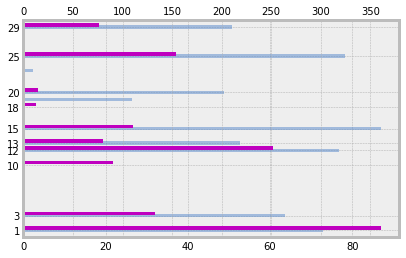

In [21]:
# show up the best K features
fig, ax1 = plt.subplots()
ax1.barh(range(30), w, height=.5, color='#5588cc', alpha=.5)
ax2 = ax1.twiny()
ax2.barh(selected_by_KBest_indexes+.3, KBest.scores_[selected_by_KBest_indexes], height=.5, color='m')
ax2.set_yticks(selected_by_KBest_indexes)
ax2.set_ylim(0,30);

In [22]:
# select the best % features based on F
from sklearn.feature_selection import SelectPercentile, f_regression

PBest = SelectPercentile(f_regression, percentile=33) # 33%
X_PF = PBest.fit_transform(X, y)

selected_by_PBest_indexes = PBest.get_support(True)
w_indexes, selected_by_PBest_indexes

(array([ 1,  3, 12, 13, 15, 19, 20, 23, 25, 29]),
 array([ 1,  3, 10, 12, 13, 15, 18, 20, 25, 29]))

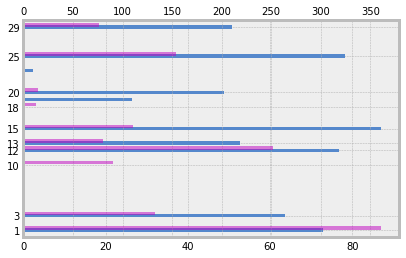

In [23]:
# show up the best P features
fig, ax1 = plt.subplots()
ax1.barh(range(30), w, height=.5, color='#5588cc')
ax2 = ax1.twiny()
ax2.barh(selected_by_PBest_indexes+.3, PBest.scores_[selected_by_PBest_indexes], height=.5, color='m', alpha=.5)
ax2.set_yticks(selected_by_PBest_indexes)
ax2.set_ylim(0,30);

In [24]:
# select features with RFE
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR
estimator = SVR(kernel="linear")
RFEsel = RFE(estimator, n_features_to_select=10, step=1)
X_RFE = RFEsel.fit_transform(X, y)
selected_by_RFEsel_indexes = RFEsel.get_support(True)
w_indexes, selected_by_RFEsel_indexes

(array([ 1,  3, 12, 13, 15, 19, 20, 23, 25, 29]),
 array([ 1,  3, 10, 12, 13, 15, 19, 20, 25, 29]))

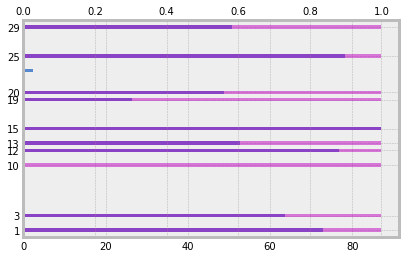

In [25]:
# show up the best features by RFE
fig, ax1 = plt.subplots()
ax1.barh(range(30), w, height=.5, color='#5588cc', alpha=1)
ax2 = ax1.twiny()
ax2.barh(selected_by_RFEsel_indexes,[1]*len(selected_by_RFEsel_indexes), height=.5, color='m', alpha=.5)
ax2.set_yticks(selected_by_RFEsel_indexes)
ax2.set_ylim(0,30);

In [26]:
# select from model - ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
est = ExtraTreesRegressor(n_estimators=100)
est.fit(X, y)
Msel = SelectFromModel(est, threshold=.014, prefit=True)
X_Msel = Msel.transform(X)
selected_by_Msel_indexes = Msel.get_support(True)
w_indexes, selected_by_Msel_indexes

(array([ 1,  3, 12, 13, 15, 19, 20, 23, 25, 29]),
 array([ 1,  3, 10, 12, 13, 15, 20, 25, 29]))

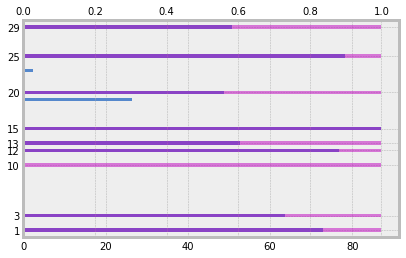

In [27]:
fig, ax1 = plt.subplots()
ax1.barh(range(30), w, height=.5, color='#5588cc')
ax2 = ax1.twiny()
ax2.barh(selected_by_Msel_indexes,[1]*len(selected_by_Msel_indexes), height=.5, color="m", alpha=.5 )
ax2.set_yticks(selected_by_Msel_indexes)
ax2.set_ylim(0,30);

In [28]:
# select from model - LassoCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
est = LassoCV(cv=5)
est.fit(X, y)
Lsel = SelectFromModel(est, threshold=1.5, prefit=True)
X_Lsel = Lsel.transform(X)
selected_by_Lsel_indexes = Lsel.get_support(True)
w_indexes, selected_by_Lsel_indexes

(array([ 1,  3, 12, 13, 15, 19, 20, 23, 25, 29]),
 array([ 0,  1,  3, 12, 13, 15, 19, 20, 25, 26, 29]))

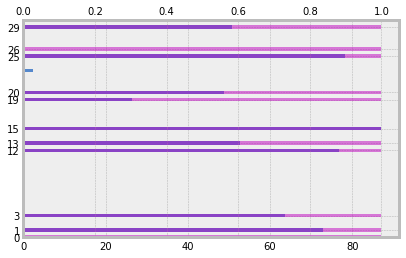

In [29]:
fig, ax1 = plt.subplots()
ax1.barh(range(30), w, height=.5, color='#5588cc')
ax2 = ax1.twiny()
ax2.barh(selected_by_Lsel_indexes,[1]*len(selected_by_Lsel_indexes), height=.5, color="m", alpha=.5 )
ax2.set_yticks(selected_by_Lsel_indexes)
ax2.set_ylim(0,30);

In [30]:
# get features from feature importances
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor(n_estimators=100)
etr.fit(X,y)

importances =  etr.feature_importances_
selected_by_etr_indexes = np.where( np.abs(importances) > 0.014 )[0]
w_indexes, selected_by_etr_indexes

(array([ 1,  3, 12, 13, 15, 19, 20, 23, 25, 29]),
 array([ 1,  3, 10, 12, 13, 15, 20, 25, 29]))

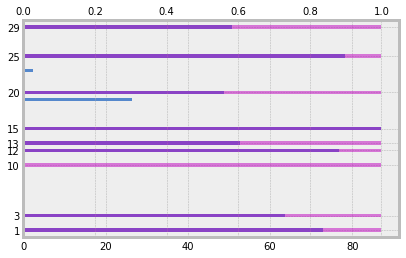

In [31]:
fig, ax1 = plt.subplots()
ax1.barh(range(30), w, height=.5, color='#5588cc')
ax2 = ax1.twiny()
ax2.barh(selected_by_etr_indexes,[1]*len(selected_by_etr_indexes), height=.5, color="m", alpha=.5 )
ax2.set_yticks(selected_by_etr_indexes)
ax2.set_ylim(0,30);

### THE END